# SYDE 522 Project Code
Chang Li, Maathusan Rajendram, Anastasia Santasheva, Evan Yeung

## Import Packages


In [1]:
# standard useful packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# validation & normalization methods
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut

# accuracy, MSE, log loss & timer methods
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from time import time

# dim reduction & classification methods 
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier

# GA stuff
import random
from deap import base, creator, tools

# make matplotlib to show plots inline
%matplotlib inline


## Set Configuration
* Select options for method validation
* Set parameters

In [2]:
# 1. set dataset
ENABLE_POR_DATA = False     # set Portugese course dataset
ENABLE_MAT_DATA = True    # set Math course dataset

# 2. set input setup
ENABLE_INPUT_SETUP_B = False   # adds the delta of G1 and G2 as a new col (GDelta)

# 3. set supervised approach for G3
ENABLE_BINARY_TARGET = True       # sets G3 to binary
ENABLE_5LEVEL_TARGET = False        # set G3 to five-level scale
ENABLE_REGRESSION_TARGET = False   # set G3 to current state for regression

# 4. set dimensionaltiy reduction method - set both to false for none
ENABLE_PCN = False
ENABLE_LDA = False

# 5. set validation type
ENABLE_KFOLD = True
ENABLE_LOO = False

# 6. set final test
ENABLE_TEST = False

## Load  Dataset
* Select a data set (Portugese course or Math course)

In [3]:
# import data from csv
if (ENABLE_POR_DATA):
    dataframe = pd.read_csv('student-por-train.csv', usecols = range(0,33)) 
    dataframe_test = pd.read_csv('student-por-test.csv', usecols = range(0,33)) 
elif (ENABLE_MAT_DATA): 
    dataframe = pd.read_csv('student-mat-train.csv', usecols = range(0,33))
    dataframe_test = pd.read_csv('student-mat-test.csv', usecols = range(0,33))

# shuffle dataset
dataframe = dataframe.sample(frac=1)

# find col length
num_cols = dataframe.shape[1]

## Preprocessing

* Convert nominal attributes with Integer + One-Hot Encoding
* Selects supervised approache for G3
* NOTE: if we want we can also split further into A,B,C (A= all cols, B=same as A without G2, C=same as B without G1)
    * But leaving this out for now since we know A gives best accuracy

In [4]:
# helper functions for preprocessing
def convertToBinary(df, num_cols):
    df.loc[(df.G3 < 10), 'G3'] = 0
    df.loc[(df.G3 >= 10), 'G3'] = 1
    
    G3 = df['G3'].values
    return G3

def convertToFiveLevel(df, num_cols):
    df.loc[(df.G3 <= 9), 'G3'] = 0
    df.loc[(df.G3 > 9) & (df.G3 <= 11), 'G3'] = 1
    df.loc[(df.G3 > 11) & (df.G3 <= 13), 'G3'] = 2
    df.loc[(df.G3 > 13) & (df.G3 <= 16), 'G3'] = 3
    df.loc[(df.G3 > 16), 'G3'] = 4
    
    G3 = df['G3'].values
    return G3   

def convertToInputSetupB(df, num_cols):
    df.insert(num_cols-1, 'GDelta', df.G2 - df.G1, allow_duplicates=True)
    
    return df

def oneHotEncode(df):
    df = df.drop(labels='G3', axis=1)
    cols_to_transform = [
                        'school',
                        'sex',
                        'address',
                        'famsize',
                        'Pstatus',
                        'Mjob',                        
                        'Fjob',
                        'reason',
                        'guardian',
                        'famsup',
                        'schoolsup',
                        'paid',
                        'activities',
                        'nursery',                        
                        'higher',
                        'internet',
                        'romantic',
                        ]
    hot_encoded_df = pd.get_dummies(df, columns = cols_to_transform)
    
    attributes = hot_encoded_df.values
    return attributes

def normalizeData(train_data, val_data):
    scaler = StandardScaler().fit(train_data)
    train_data = scaler.transform(train_data)
    val_data = scaler.transform(val_data)
    
    return train_data, val_data

# labels of Y
labels = []

# switch to input setup B
if (ENABLE_INPUT_SETUP_B): 
    dataframe = convertToInputSetupB(dataframe, num_cols)
    dataframe_test = convertToInputSetupB(dataframe_test, num_cols)

# split one-hot encoded attributes (X) and G3 (Y)
X = oneHotEncode(dataframe)
X_tst = oneHotEncode(dataframe_test)

# selects supervised approach for G3
if (ENABLE_BINARY_TARGET):
    Y = convertToBinary(dataframe, num_cols).astype('int')
    Y_tst = convertToBinary(dataframe_test, num_cols).astype('int')
    labels = [0, 1]
elif (ENABLE_5LEVEL_TARGET):
    Y = convertToFiveLevel(dataframe, num_cols).astype('int')
    Y_tst = convertToFiveLevel(dataframe_test, num_cols).astype('int')
    labels = [0, 1, 2, 3, 4]
elif (ENABLE_REGRESSION_TARGET):
    Y = dataframe['G3'].values.astype('int')
    Y_tst = dataframe_test['G3'].values.astype('int')
    

In [5]:
# Y
X.shape, Y.shape, X_tst.shape, Y_tst.shape

((316, 58), (316,), (79, 58), (79,))

## Dimensionality Reduction
* PCA & LDA reduction methods

In [6]:
def pcaReduction(train_data, val_data, n_comp):
    pca = PCA(n_components=n_comp)
    train_data = pca.fit_transform(train_data)
    val_data = pca.transform(val_data)
    
    return train_data, val_data

def ldaReduction(train_data, train_target, val_data, n_comp):
    lda = LinearDiscriminantAnalysis(n_components=n_comp)
    train_data = lda.fit_transform(train_data, train_target)
    val_data = lda.transform(val_data)
    
    return train_data, val_data


## Make NN Class

In [7]:
# First parameter is the number of hidden layers
# Remaining parameters are number of nodes in that layer
def createNNIndividual(params):
    num_hidden_layers = params[0] - 1
    hidden_layers = tuple(params[1:num_hidden_layers + 1])
    model = MLPClassifier(solver='lbfgs', hidden_layer_sizes=tuple(params))
    return model

## Classifier Selection
* Select classifer to validate

In [8]:
# method to build classifier
def buildClf(train_data, train_target, params):
    if(ENABLE_REGRESSION_TARGET):
        model = createNNIndividual(params)
    else:
        # built nn
        model = createNNIndividual(params)

    model.fit(train_data, train_target)
    return model

## Build and run GA

In [9]:
# because of the way this is encoded, it works better if they're the same :/
MAX_LAYERS = 10
MAX_NODES_PER_LAYER = 10

# Add creators
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Build toolbox
toolbox = base.Toolbox()
toolbox.register("attr_int", random.randint, 1, MAX_NODES_PER_LAYER)
# add 2 as first int is the num_layers - 1
toolbox.register("individual", tools.initRepeat,
                 creator.Individual, toolbox.attr_int, MAX_LAYERS + 2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [10]:
# method to calculate accuracy (PCC) & RMSE
def calcMetric(actual, predicted):
    if(ENABLE_REGRESSION_TARGET): return (mean_squared_error(actual, predicted))**(0.5) # calculates RMSE
    else: return accuracy_score(actual, predicted, normalize = True) # calculates PCC


def evaluateIndividual(nn_params):
    n_comp = 40
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)

    # normalize data
    X_train, X_val = normalizeData(X_train, X_val)

    # reduce dimensionality
    if (ENABLE_PCN): X_train, X_val = pcaReduction(X_train, X_val, n_comp)
    elif (ENABLE_LDA): X_train, X_val = ldaReduction(X_train, Y_train, X_val, n_comp)

    # build classifier for each set
    clf = buildClf(X_train, Y_train, nn_params)

    predicted = clf.predict(X_val)
    val_accuracy = calcMetric(Y_val, predicted)
        
    return val_accuracy

In [11]:
toolbox.register("evaluate", evaluateIndividual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=1, up=MAX_NODES_PER_LAYER, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

In [13]:
def mainGA():
    POP_SIZE=40
    CXPB = 0.6
    MUTPB = 0.4
    NGEN = 70
    
    cols = ['gen', 'min_val', 'max_val', 'avg', 'std']
    all_results = pd.DataFrame(columns=cols)
    all_populations = []

    # create population
    pop = toolbox.population(n=POP_SIZE)
    all_populations.append(list(map(toolbox.clone, pop)))

    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = (fit,)

    # Extracting all the fitnesses of pop
    fits = [ind.fitness.values[0] for ind in pop]
    
    # Variable keeping track of the number of generations
    g = 0
    
    # Begin the evolution
    while max(fits) < 100 and g < NGEN:
        # A new generation
        g = g + 1
        
        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))
        
        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values
                
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = (fit,)

        # The population is entirely replaced by the offspring
        pop[:] = offspring
        fits = [ind.fitness.values[0] for ind in pop]
        
        all_populations.append(list(map(toolbox.clone, pop)))
        
        ## THIS IS JUST FOR METRICS
        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5
        
        generation_results = pd.DataFrame([[g, min(fits), max(fits), mean, std]], columns=cols)
        all_results = all_results.append(generation_results)
        print(generation_results)

    return all_populations, all_results

populations, results = mainGA()

/Users/evan/.virtualenvs/machine_intelligence/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


   gen  min_val  max_val       avg       std
0    1   0.5625  0.90625  0.695312  0.083048
   gen  min_val  max_val      avg       std
0    2  0.53125  0.90625  0.70625  0.089021
   gen   min_val  max_val       avg       std
0    3  0.484375    0.875  0.705078  0.087917
   gen  min_val   max_val       avg       std
0    4  0.53125  0.921875  0.733594  0.103169
   gen  min_val   max_val       avg       std
0    5  0.53125  0.921875  0.739453  0.110783
   gen  min_val  max_val       avg       std
0    6  0.53125  0.90625  0.758984  0.099184
   gen   min_val   max_val       avg       std
0    7  0.546875  0.890625  0.726172  0.096887
   gen  min_val  max_val       avg       std
0    8   0.5625  0.90625  0.742969  0.101379
   gen  min_val   max_val       avg       std
0    9  0.59375  0.921875  0.796875  0.080738
   gen  min_val   max_val       avg       std
0   10   0.5625  0.921875  0.764844  0.107288
   gen   min_val   max_val       avg       std
0   11  0.578125  0.921875  0.803906  0.0

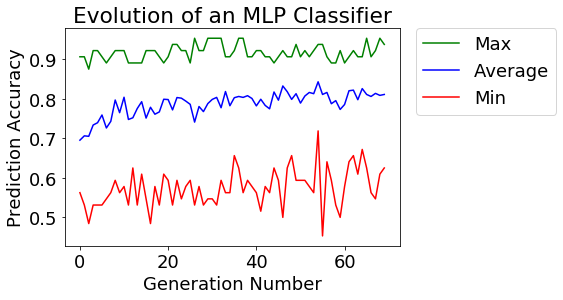

In [23]:
gens = [i for i in range(results.shape[0])]
plt.plot(gens, results.max_val, 'g', label='Max')
plt.plot(gens, results.avg, 'b', label='Average')
plt.plot(gens, results.min_val, 'r', label='Min')

plt.ylabel('Prediction Accuracy')
plt.xlabel('Generation Number')
plt.title('Evolution of an MLP Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

font = {'weight' : 'normal', 'size'   : 18}
plt.rc('font', **font)

plt.show()

## Validation Methods
* k-Fold cross validation & Leave-one-out validation
* data gets normalized here

In [75]:
def kFoldValidation(n_comp, params, n_splits=10):
    kFold = KFold(n_splits=n_splits)
    
    # run on validation data
    val_results = []
    train_results = []
    log_loss_results = []
    time_log = []
    
    for train_index, val_index in kFold.split(X):
        #start timer, return avg time below
        start = time()
        
        X_train, X_val = X[train_index], X[val_index]
        Y_train, Y_val = Y[train_index], Y[val_index]
        
        # normalize data
        X_train, X_val = normalizeData(X_train, X_val)
        
        # reduce dimensionality
        if (ENABLE_PCN): X_train, X_val = pcaReduction(X_train, X_val, n_comp)
        elif (ENABLE_LDA): X_train, X_val = ldaReduction(X_train, Y_train, X_val, n_comp)
        
        # build classifier for each set
        clf = buildClf(X_train, Y_train, params)
        
        predicted = clf.predict(X_val)
        val_accuracy = calcMetric(Y_val, predicted)
        predicted = clf.predict(X_train)
        train_accuracy = calcMetric(Y_train, predicted)
        
        # log loss calculation - for classification only
        if(not ENABLE_REGRESSION_TARGET): log_loss_results.append(log_loss(Y_val, clf.predict_proba(X_val), labels=labels))
        
        val_results.append(val_accuracy)
        train_results.append(train_accuracy)
        time_log.append(time()-start)
        
    return np.mean(train_results, axis = 0), np.mean(val_results, axis = 0), np.mean(log_loss_results, axis = 0), np.mean(time_log, axis = 0)

def looValidation(n_comp, params):
    loo = LeaveOneOut()
    
    # run on validation data
    val_results = []
    train_results = []
    Y_test_prob = []
    log_loss_value = 0
    time_log = []
    
    for train_index, val_index in loo.split(X):
        #start timer, return avg time below
        start = time()
        
        X_train, X_val = X[train_index], X[val_index]
        Y_train, Y_val = Y[train_index], Y[val_index]
        
        # normalize data
        X_train, X_val = normalizeData(X_train, X_val)
        
        # reduce dimensionality
        if (ENABLE_PCN): X_train, X_val = pcaReduction(X_train, X_val, n_comp)
        elif (ENABLE_LDA): X_train, X_val = ldaReduction(X_train, Y_train, X_val, n_comp)
        
        # build classifier for each set
        clf = buildClf(X_train, Y_train, params)
        
        predicted = clf.predict(X_val)
        val_accuracy = calcMetric(Y_val, predicted)
        predicted = clf.predict(X_train)
        train_accuracy = calcMetric(Y_train, predicted)
        
        # save probability for log loss calculation
        if(not ENABLE_REGRESSION_TARGET): Y_test_prob.append(clf.predict_proba(X_val)[0])
            
        test_results.append(test_accuracy)
        val_results.append(val_accuracy)
        train_results.append(train_accuracy)
        time_log.append(time()-start)
    
    # log loss calculation - for classification only
    if(not ENABLE_REGRESSION_TARGET): log_loss_value = log_loss(Y, Y_test_prob, labels=labels)

    return np.mean(train_results, axis = 0), np.mean(val_results, axis = 0), log_loss_value, np.mean(time_log, axis = 0)

In [76]:
def evalFinalPopulation(pop):
    cols = ['param', 'Time', 'Acc', 'logloss']
    all_results = pd.DataFrame(columns=cols)
    for ind in best_pop:
        train_res, val_res, log_loss_val, time_val = kFoldValidation(40, ind, 10)
        all_results = all_results.append(pd.DataFrame([[ind, time_val, val_res, log_loss_val]], columns=cols))
    return all_results

best_pop = populations[-1]
best_results = evalFinalPopulation(best_pop)
best_results

/Users/evan/.virtualenvs/machine_intelligence/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/evan/.virtualenvs/machine_intelligence/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/evan/.virtualenvs/machine_intelligence/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,param,Time,Acc,logloss
0,"[8, 4, 5, 9, 5, 3, 2, 8, 8, 9, 4, 7]",0.768739,3.118943,NaN
0,"[8, 3, 5, 9, 10, 3, 2, 8, 8, 9, 4, 7]",0.296044,3.254282,NaN
0,"[8, 4, 5, 10, 5, 3, 5, 8, 8, 9, 7, 7]",0.773066,2.443326,NaN
0,"[8, 4, 5, 9, 5, 3, 2, 8, 8, 9, 8, 8]",0.720739,2.942293,NaN
0,"[8, 4, 5, 9, 10, 3, 2, 8, 8, 9, 4, 7]",0.588419,2.931215,NaN
0,"[8, 4, 5, 9, 10, 3, 2, 8, 8, 9, 4, 7]",0.592376,2.853500,NaN
0,"[8, 3, 5, 10, 5, 3, 3, 8, 8, 9, 4, 7]",0.459756,3.340805,NaN
0,"[8, 4, 5, 9, 5, 3, 3, 8, 8, 9, 7, 7]",1.024232,3.018236,NaN
0,"[8, 3, 8, 7, 10, 3, 2, 8, 8, 9, 3, 7]",0.526288,3.254372,NaN
0,"[8, 3, 5, 9, 5, 3, 2, 8, 8, 9, 4, 7]",0.389750,2.911015,NaN


In [77]:
max(best_results.Acc)

3.4529106251902157

## Obtain Accuracy, Log Loss & Error
* Adjust array of penalty parameters
* Graphs error and log loss - for classification only

In [ ]:
# input reduced dimension - this can be ignored if none selected
n_comp = 45

# input parameter iterations - can tune other params in classifer selection method above
if(not ENABLE_TEST):
    # hyperparams = [None]
    hyperparams = [(5, 0, 3)]
else: hyperparams = [(5)] # input best parameter for test

# results array format: [[train], [validation], [log loss]]
results = [[],[],[]]

# calculate train error, test error, log loss & time for specific param
for penalty in hyperparams:
    
    if (ENABLE_KFOLD): train_res, val_res, log_loss_val, time_val = kFoldValidation(n_comp, penalty, 10)
    elif (ENABLE_LOO): train_res, val_res, log_loss_val, time_val = looValidation(n_comp, penalty)
    
    # save error, RMSE, log loss for each penalty for graph
    if (not ENABLE_REGRESSION_TARGET):
        results[0].append(1-train_res)
        results[1].append(1-val_res)
        results[2].append(log_loss_val)
    elif (ENABLE_REGRESSION_TARGET):
        results[0].append(train_res)
        results[1].append(val_res)

    print ("-----C={}-----".format(penalty))
    print ("Time: {} seconds".format(time_val))
    print ("-----Train-----")
    print ("Accuracy/RMSE: {}".format(train_res))
    print ("-----Validation-----")
    print ("Accuracy/RMSE: {}".format(val_res))
    print ("Log Loss: {}\n".format(log_loss_val))
    
# run best model on unseen test set
if(ENABLE_TEST):
    test_accuracy, test_log_loss, test_time = runTestSet(X, Y, X_tst, Y_tst, n_comp, hyperparams[0])

    print ("-----Test-----")
    print ("Accuracy/RMSE: {}".format(test_accuracy))
    print ("Log Loss: {}".format(test_log_loss))
    print ("Time: {} seconds".format(test_time))

# create error and log loss graph for penalty iterations - classification only
if(not ENABLE_REGRESSION_TARGET and len(hyperparams) > 1):
    f, axarr = plt.subplots(2, sharex=False)
    f.suptitle('Error and Log Loss', y = 0.92)
    f.set_size_inches(10, 10)

    # subplot 1: error plot
    axarr[0].set_ylabel('Error')
    axarr[0].plot(hyperparams, results[0], color='r', label='train')
    axarr[0].plot(hyperparams, results[1], color='b', label='validation')
    axarr[0].set_xticks(hyperparams)
    axarr[0].legend()

    # subplot 2: log loss plot
    axarr[1].set_ylabel('Log Loss')
    axarr[1].plot(hyperparams, results[2], color='g', label='log loss')
    axarr[1].set_xticks(hyperparams)
    axarr[1].set_xlabel('Parameter')
    plt.show()
    
# create RMSE graph for penalty iterations - regression only
if(ENABLE_REGRESSION_TARGET and len(hyperparams) > 1):
    f, axarr = plt.subplots(sharex=False)
    f.suptitle('RMSE', y = 0.92)
    f.set_size_inches(10, 5)

    # subplot 1: RMSE plot
    axarr.set_ylabel('RMSE')
    axarr.plot(hyperparams, results[0], color='r', label='train')
    axarr.plot(hyperparams, results[1], color='b', label='validation')
    axarr.set_xticks(hyperparams)
    axarr.set_xlabel('Parameter')
    axarr.legend()
    plt.show()

## Final Test Method
* Run best classifier on unseen test set

In [ ]:
# get accuracy/RMSE, logloss and time 
def runTestSet(X_train, Y_train, X_test, Y_test, n_comp, params):
    
    start = time()
    test_log_loss = 0
    
    # normalize data
    X_train, X_test = normalizeData(X_train, X_test)

    # reduce dimensionality
    if (ENABLE_PCN): X_train, X_test = pcaReduction(X_train, X_test, n_comp)
    elif (ENABLE_LDA): X_train, X_test = ldaReduction(X_train, Y_train, X_test, n_comp)

    # build classifier, predict and get accuracy
    clf = buildClf(X_train, Y_train, params)
    predicted = clf.predict(X_test)
    test_accuracy = calcMetric(Y_test, predicted)
    
    # log loss calculation - for classification only
    if(not ENABLE_REGRESSION_TARGET): test_log_loss = log_loss(Y_test, clf.predict_proba(X_test))
        
    # execution time calculation
    test_time = time()-start
    
    return test_accuracy, test_log_loss, test_time